# HDBSCAN: Hierarchical Density-Based Spatial Clustering
## A Complete Mathematical and Visual Guide

**HDBSCAN** = Hierarchical Density-Based Spatial Clustering of Applications with Noise

### What You'll Learn:
1. The mathematical foundations of each HDBSCAN step
2. How to visualize each stage of the algorithm
3. How to apply it to your own datasets
4. How to interpret and tune parameters

---

## Setup and Imports

In [36]:
# Install required packages (uncomment if needed)
# !pip install hdbscan scikit-learn matplotlib numpy pandas scipy seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import hdbscan
import warnings
from IPython.display import display, Markdown

# Filter out specific FutureWarnings from hdbscan
warnings.filterwarnings('ignore', category=FutureWarning, message='.*force_all_finite.*')
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

---
## Section I. Data Preparation
First, we'll create or load our dataset. You can use the synthetic data provided or load your own.

In [ ]:
# =============================================================================
# CONFIGURATION: Set this to False to use your own data
# =============================================================================
# =============================================================================
# DATASET SELECTION
# =============================================================================

# Choose your dataset option:
# 1. 'synthetic' - Generated data (good for quick testing)
# 2. 'mall_customers' - Mall Customer Segmentation (2D: Annual Income vs Spending Score)
# 3. 'credit_card' - Credit Card Customer Clustering (2D PCA projection)
# 4. 'custom' - Load your own CSV file

DATASET_CHOICE = 'mall_customers'  # Change this to your preference

# For 'custom' option, specify your file path and columns
CUSTOM_FILE_PATH = 'your_data.csv'
CUSTOM_FEATURE_COLUMNS = ['feature1', 'feature2']  # Column names to use

print(f"Selected dataset: {DATASET_CHOICE}")
print("=" * 70)

# =============================================================================
# LOAD DATASET
# =============================================================================

if DATASET_CHOICE == 'synthetic':
    # Create synthetic dataset with 3 distinct clusters plus noise
    X_clusters, y_true = make_blobs(
        n_samples=300, 
        centers=3, 
        n_features=2,
        center_box=(-10, 10), 
        cluster_std=1.2, 
        random_state=42
    )
    
    # Add noise points (outliers)
    X_noise = np.random.uniform(low=-12, high=12, size=(30, 2))
    X = np.vstack([X_clusters, X_noise])
    y_true = np.hstack([y_true, -np.ones(30, dtype=int)])
    
    feature_names = ['Feature 1', 'Feature 2']
    print(f"Synthetic dataset created")
    print(f"Shape: {X.shape}")
    print(f"Features: {X.shape[1]}")
    print(f"Total points: {X.shape[0]}")
    print(f"True clusters: 3 + noise")

elif DATASET_CHOICE == 'mall_customers':
    # Mall Customer Segmentation Dataset
    # Kaggle: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
    
    try:
        # Try to download directly (requires kaggle API setup)
        # Or you can manually download and place in the same directory
        df = pd.read_csv('Mall_Customers.csv')
    except FileNotFoundError:
        print("Mall_Customers.csv not found. Creating sample data...")
        print("To use real data:")
        print("1. Download from: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python")
        print("2. Place 'Mall_Customers.csv' in the notebook directory")
        print("3. Re-run this cell\n")
        
        # Create sample data with similar characteristics
        np.random.seed(42)
        n_samples = 200
        
        # Create 5 distinct customer segments
        centers = [(50, 50), (25, 75), (75, 25), (50, 20), (25, 25)]
        segments = []
        
        for center in centers:
            segment = np.random.multivariate_normal(
                center, 
                [[100, 0], [0, 100]], 
                size=n_samples // 5
            )
            segments.append(segment)
        
        X = np.vstack(segments)
        X[:, 0] = np.clip(X[:, 0], 15, 100)  # Annual Income (k$)
        X[:, 1] = np.clip(X[:, 1], 1, 100)   # Spending Score (1-100)
        
        feature_names = ['Annual Income (k$)', 'Spending Score (1-100)']
        print("Sample Mall Customers data created")
    else:
        # Use Annual Income and Spending Score for clustering
        X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
        feature_names = ['Annual Income (k$)', 'Spending Score (1-100)']
        print(f"Mall Customers dataset loaded from file")
    
    print(f"Shape: {X.shape}")
    print(f"Features: {feature_names}")
    print(f"Total points: {X.shape[0]}")
    print(f"Description: Customer segmentation based on income and spending behavior")

elif DATASET_CHOICE == 'credit_card':
    # Credit Card Dataset for Clustering
    # Kaggle: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
    
    try:
        df = pd.read_csv('CC_GENERAL.csv')
    except FileNotFoundError:
        print("CC_GENERAL.csv not found. Creating sample data...")
        print("To use real data:")
        print("1. Download from: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata")
        print("2. Place 'CC_GENERAL.csv' in the notebook directory")
        print("3. Re-run this cell\n")
        
        # Create sample data
        np.random.seed(42)
        n_samples = 8950
        X_full = np.random.gamma(2, 2, size=(n_samples, 17))
        print("Sample Credit Card data created")
    else:
        # Drop CUST_ID and handle missing values
        df = df.drop('CUST_ID', axis=1, errors='ignore')
        df = df.fillna(df.median())
        X_full = df.values
        print(f"Credit Card dataset loaded from file")
    
    # Use PCA to reduce to 2D
    from sklearn.decomposition import PCA
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    
    pca = PCA(n_components=2)
    X = pca.fit_transform(X_scaled)
    
    feature_names = ['PC1', 'PC2']
    print(f"Shape: {X.shape}")
    print(f"Original features: {X_full.shape[1]}")
    print(f"Reduced to 2D using PCA")
    print(f"Explained variance: {pca.explained_variance_ratio_[0]:.2%} + {pca.explained_variance_ratio_[1]:.2%} = {pca.explained_variance_ratio_.sum():.2%}")
    print(f"Total points: {X.shape[0]}")

elif DATASET_CHOICE == 'custom':
    # Load your own dataset
    try:
        df = pd.read_csv(CUSTOM_FILE_PATH)
        print(f"Custom dataset loaded from {CUSTOM_FILE_PATH}")
        print(f"Available columns: {list(df.columns)}")
        
        # Select features
        X = df[CUSTOM_FEATURE_COLUMNS].values
        feature_names = CUSTOM_FEATURE_COLUMNS
        
        # Check for missing values
        if pd.DataFrame(X).isnull().any().any():
            print("Warning: Missing values detected. Filling with median...")
            X = pd.DataFrame(X).fillna(pd.DataFrame(X).median()).values
        
        # Standardize if features have different scales
        if X.std(axis=0).max() / X.std(axis=0).min() > 10:
            print("Features have different scales. Standardizing...")
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        
        print(f"Shape: {X.shape}")
        print(f"Features: {feature_names}")
        print(f"Total points: {X.shape[0]}")
        
    except FileNotFoundError:
        print(f"Error: File '{CUSTOM_FILE_PATH}' not found!")
        print("Please check the file path and try again.")
        raise
    except KeyError as e:
        print(f"Error: Column {e} not found in dataset!")
        print(f"Available columns: {list(df.columns)}")
        raise

else:
    print(f"Error: Unknown dataset choice '{DATASET_CHOICE}'")
    print("Valid options: 'synthetic', 'credit_card', 'custom'")
    raise ValueError(f"Unknown dataset choice: {DATASET_CHOICE}")

# Store feature names for later use in plots
if 'feature_names' not in locals():
    feature_names = ['Feature 1', 'Feature 2']

print("\nDataset ready for clustering!")

Selected dataset: mall_customers
Mall Customers dataset loaded from file
Shape: (200, 2)
Features: ['Annual Income (k$)', 'Spending Score (1-100)']
Total points: 200
Description: Customer segmentation based on income and spending behavior

Dataset ready for clustering!


### Visualize the original data
Some datasets have many features (dimensions). 

For example:
- Credit card dataset: 17 features (balance, purchases, credit limit, payments, etc.)
- Wholesale customers: 6 features (Fresh, Milk, Grocery, Frozen, etc.)

Problem: We can't easily visualize 17-dimensional data on a 2D screen

Solution: Use PCA to compress it down to 2 dimensions while keeping the most important information.

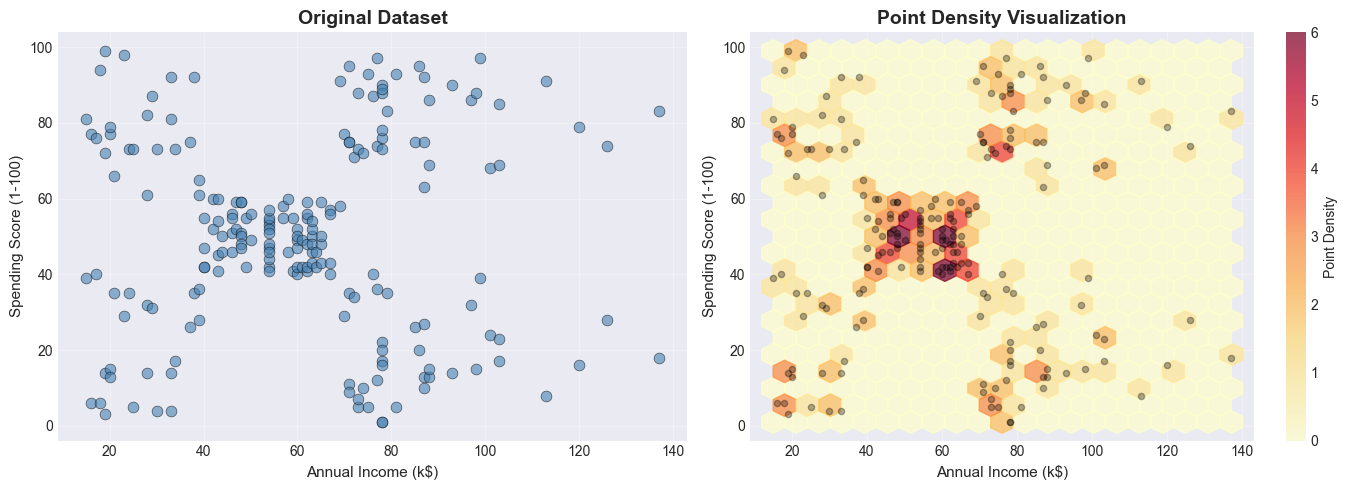

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot
axes[0].scatter(X[:, 0], X[:, 1], s=60, alpha=0.6, c='steelblue', 
                edgecolors='black', linewidth=0.5)
axes[0].set_title('Original Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel(feature_names[0], fontsize=11)
axes[0].set_ylabel(feature_names[1], fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Density visualization using hexbin
hb = axes[1].hexbin(X[:, 0], X[:, 1], gridsize=20, cmap='YlOrRd', alpha=0.7)
axes[1].scatter(X[:, 0], X[:, 1], s=20, alpha=0.3, c='black')
plt.colorbar(hb, ax=axes[1], label='Point Density')
axes[1].set_title('Point Density Visualization', fontsize=14, fontweight='bold')
axes[1].set_xlabel(feature_names[0], fontsize=11)
axes[1].set_ylabel(feature_names[1], fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Section II. Step-by-Step Rundown

### Step 1: Core Distance Computation

### Mathematical Definition

The **core distance** of a point $p$ with parameter $k$ is defined as:

$$\text{core}_k(p) = d(p, N_k(p))$$

where:
- $N_k(p)$ is the $k$-th nearest neighbor of point $p$
- $d(p, N_k(p))$ is the distance from $p$ to its $k$-th nearest neighbor

### Intuition

The core distance measures the **local density** around each point:
- **Small core distance** → Point is in a dense region
- **Large core distance** → Point is isolated or in a sparse region

### Parameter: `min_samples`

This parameter $k$ determines how many neighbors to consider. Typical values range from 5-15.


### Section II.I Distance Calculation Method

Euclidean Distance (Most Common - Used by HDBSCAN)

This is the "straight-line" distance from one point to another

Formula for 2D: 
$$ d(p, q) = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2} $$
where: 
- $ p = (p_{x}, p_{y}) $ is point p with coordinates (x, y)
- $ q = (q_{x}, q_{y}) $ is point q with coordinates (x, y)

Formula for 3D:
$$ d(p, q) = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2 + (p_z - q_z)^2} $$
where:
- $ p = (p_{x}, p_{y}, p_{z}) $ is point p with coordinates (x, y, z)
- $ q = (q_{x}, q_{y}, q_{z}) $ is point q with coordinates (x, y, z)

Formula for n-dimensional distances (General form):
$$ d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2} $$
where:
- p and q are n-dimensional points

In [39]:
# =============================================================================
# STEP 1: COMPUTE CORE DISTANCES
# =============================================================================

min_samples = 5  # Parameter: k in the formula above

print(f"Computing core distances with min_samples = {min_samples}")
print("=" * 70)

# Compute pairwise Euclidean distances
distance_matrix = squareform(pdist(X, metric='euclidean'))

# For each point, find the k-th nearest neighbor distance
core_distances = np.zeros(len(X))

for i in range(len(X)):
    # Get distances from point i to all other points
    distances_from_i = distance_matrix[i]
    
    # Sort distances (exclude distance to self which is 0)
    sorted_distances = np.sort(distances_from_i)
    
    # The k-th nearest neighbor (1-indexed, so we use min_samples)
    core_distances[i] = sorted_distances[min_samples]

# Statistics
print(f"\nCore Distance Statistics:")
print(f"   • Minimum:  {core_distances.min():.4f}")
print(f"   • Mean:     {core_distances.mean():.4f}")
print(f"   • Median:   {np.median(core_distances):.4f}")
print(f"   • Maximum:  {core_distances.max():.4f}")
print(f"   • Std Dev:  {core_distances.std():.4f}")

# Display example calculations for first 3 points
print(f"\nExample: Core distances for first 3 points:")
for i in range(3):
    neighbors_dists = np.sort(distance_matrix[i])[1:min_samples+1]
    print(f"\n   Point {i}:")
    print(f"      Distances to {min_samples} nearest neighbors: {neighbors_dists}")
    print(f"      Core distance (k={min_samples}): {core_distances[i]:.4f}")


Computing core distances with min_samples = 5

Core Distance Statistics:
   • Minimum:  2.0000
   • Mean:     7.7126
   • Median:   6.2037
   • Maximum:  36.7696
   • Std Dev:  5.1852

Example: Core distances for first 3 points:

   Point 0:
      Distances to 5 nearest neighbors: [ 2.23606798  7.21110255  9.8488578  12.80624847 14.76482306]
      Core distance (k=5): 14.7648

   Point 1:
      Distances to 5 nearest neighbors: [4.12310563 5.38516481 5.38516481 6.40312424 9.8488578 ]
      Core distance (k=5): 9.8489

   Point 2:
      Distances to 5 nearest neighbors: [2.         4.24264069 8.06225775 8.54400375 9.05538514]
      Core distance (k=5): 9.0554


### Visualization: Core Distances

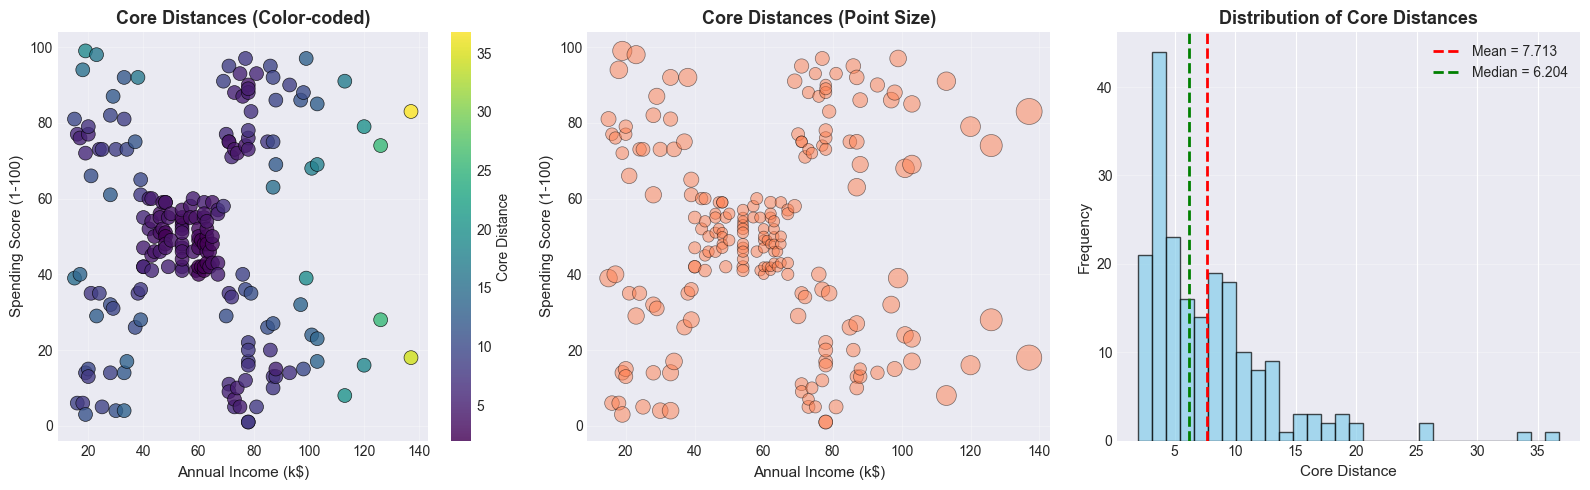

In [40]:
fig = plt.figure(figsize=(16, 5))

# Plot 1: Core distances as colors
ax1 = plt.subplot(131)
scatter = ax1.scatter(X[:, 0], X[:, 1], c=core_distances, s=100, 
                      cmap='viridis', edgecolors='black', linewidth=0.5, alpha=0.8)
cbar = plt.colorbar(scatter, ax=ax1, label='Core Distance')
ax1.set_title('Core Distances (Color-coded)', fontsize=13, fontweight='bold')
ax1.set_xlabel(feature_names[0], fontsize=11)
ax1.set_ylabel(feature_names[1], fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Core distances as point sizes
ax2 = plt.subplot(132)
sizes = (core_distances - core_distances.min()) / (core_distances.max() - core_distances.min()) * 300 + 50
ax2.scatter(X[:, 0], X[:, 1], s=sizes, alpha=0.5, c='coral', edgecolors='black', linewidth=0.5)
ax2.set_title('Core Distances (Point Size)', fontsize=13, fontweight='bold')
ax2.set_xlabel(feature_names[0], fontsize=11)
ax2.set_ylabel(feature_names[1], fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of core distances
ax3 = plt.subplot(133)
ax3.hist(core_distances, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax3.axvline(core_distances.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {core_distances.mean():.3f}')
ax3.axvline(np.median(core_distances), color='green', linestyle='--', linewidth=2, label=f'Median = {np.median(core_distances):.3f}')
ax3.set_xlabel('Core Distance', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution of Core Distances', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Visualizing k-Nearest Neighbors

Let's visualize the k-nearest neighbors for a few sample points:

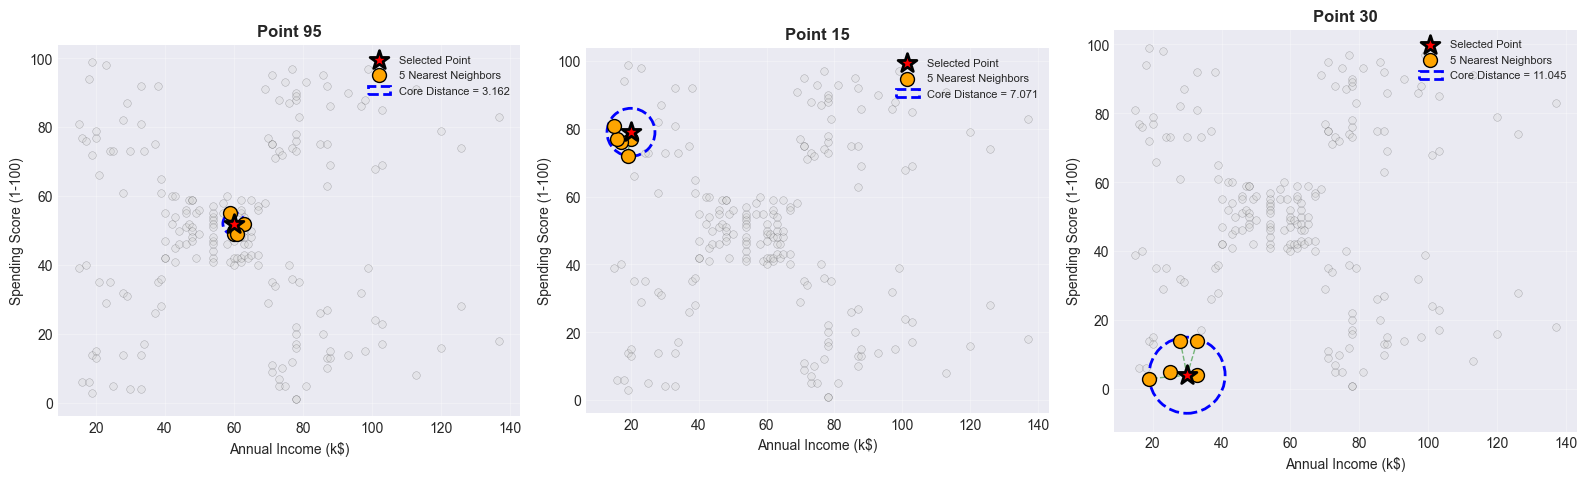

In [41]:
# Visualize k-nearest neighbors for 3 random points
sample_points = np.random.choice(len(X), 3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, point_idx in enumerate(sample_points):
    ax = axes[idx]
    
    # Plot all points
    ax.scatter(X[:, 0], X[:, 1], s=30, alpha=0.3, c='lightgray', edgecolors='black', linewidth=0.3)
    
    # Highlight the selected point
    ax.scatter(X[point_idx, 0], X[point_idx, 1], s=200, c='red', 
               edgecolors='black', linewidth=2, marker='*', label='Selected Point', zorder=5)
    
    # Find and highlight k-nearest neighbors
    distances_from_point = distance_matrix[point_idx]
    k_nearest_indices = np.argsort(distances_from_point)[1:min_samples+1]  # Exclude self
    
    ax.scatter(X[k_nearest_indices, 0], X[k_nearest_indices, 1], 
               s=100, c='orange', edgecolors='black', linewidth=1, 
               label=f'{min_samples} Nearest Neighbors', zorder=4)
    
    # Draw lines to nearest neighbors
    for neighbor_idx in k_nearest_indices:
        ax.plot([X[point_idx, 0], X[neighbor_idx, 0]], 
                [X[point_idx, 1], X[neighbor_idx, 1]], 
                'g--', alpha=0.5, linewidth=1)
    
    # Draw circle at core distance
    circle = plt.Circle((X[point_idx, 0], X[point_idx, 1]), 
                        core_distances[point_idx], 
                        color='blue', fill=False, linewidth=2, 
                        linestyle='--', label=f'Core Distance = {core_distances[point_idx]:.3f}')
    ax.add_patch(circle)
    
    ax.set_title(f'Point {point_idx}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature_names[0], fontsize=10)
    ax.set_ylabel(feature_names[1], fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


### Step 2: Mutual Reachability Distance

### Mathematical Definition

The **mutual reachability distance** between two points $a$ and $b$ is defined as:

$$d_{\text{mreach}}(a, b) = \max\{\text{core}_k(a), \text{core}_k(b), d(a, b)\}$$

where:
- $\text{core}_k(a)$ is the core distance of point $a$
- $\text{core}_k(b)$ is the core distance of point $b$  
- $d(a, b)$ is the Euclidean distance between $a$ and $b$

### Intuition

This distance metric ensures that:
1. Points must be **at least as far** as their core distances
2. **Prevents outliers** from being pulled into dense clusters
3. **Smooths** the distance metric based on local density

### Why This Matters

Traditional distances can cause problems:
- An outlier might be close to a dense cluster in absolute distance
- But it's not in a dense region itself
- Mutual reachability distance accounts for this!

In [42]:
# =============================================================================
# STEP 2: COMPUTE MUTUAL REACHABILITY DISTANCE MATRIX
# =============================================================================

n_points = len(X)
mutual_reachability_matrix = np.zeros((n_points, n_points))

for i in range(n_points):
    for j in range(n_points):
        if i == j:
            mutual_reachability_matrix[i, j] = 0
        else:
            mutual_reachability_matrix[i, j] = max(
                core_distances[i],
                core_distances[j],
                distance_matrix[i, j]
            )

print(f"Mutual reachability matrix computed: {mutual_reachability_matrix.shape}")

# Show examples
print(f"\nExamples of Mutual Reachability Distance:")
print(f"{'':>10} {'Point A':<8} {'Point B':<8} {'Euclidean':<12} {'Core(A)':<12} {'Core(B)':<12} {'Mutual Reach.':<15}")
print("-" * 85)

for i in range(min(5, n_points)):
    j = (i + 1) % n_points
    euclidean = distance_matrix[i, j]
    core_a = core_distances[i]
    core_b = core_distances[j]
    mutual = mutual_reachability_matrix[i, j]
    
    # Identify which value was the max
    max_component = "Euclidean" if euclidean >= max(core_a, core_b) else ("Core(A)" if core_a >= core_b else "Core(B)")
    
    print(f"{'':>10} {i:<8} {j:<8} {euclidean:<12.4f} {core_a:<12.4f} {core_b:<12.4f} {mutual:<15.4f} ← {max_component}")


Mutual reachability matrix computed: (200, 200)

Examples of Mutual Reachability Distance:
           Point A  Point B  Euclidean    Core(A)      Core(B)      Mutual Reach.  
-------------------------------------------------------------------------------------
           0        1        42.0000      14.7648      9.8489       42.0000         ← Euclidean
           1        2        75.0067      9.8489       9.0554       75.0067         ← Euclidean
           2        3        71.0000      9.0554       5.8310       71.0000         ← Euclidean
           3        4        37.0135      5.8310       13.6015      37.0135         ← Euclidean
           4        5        36.0000      13.6015      5.3852       36.0000         ← Euclidean


### Visualization: Comparing Distance Metrics

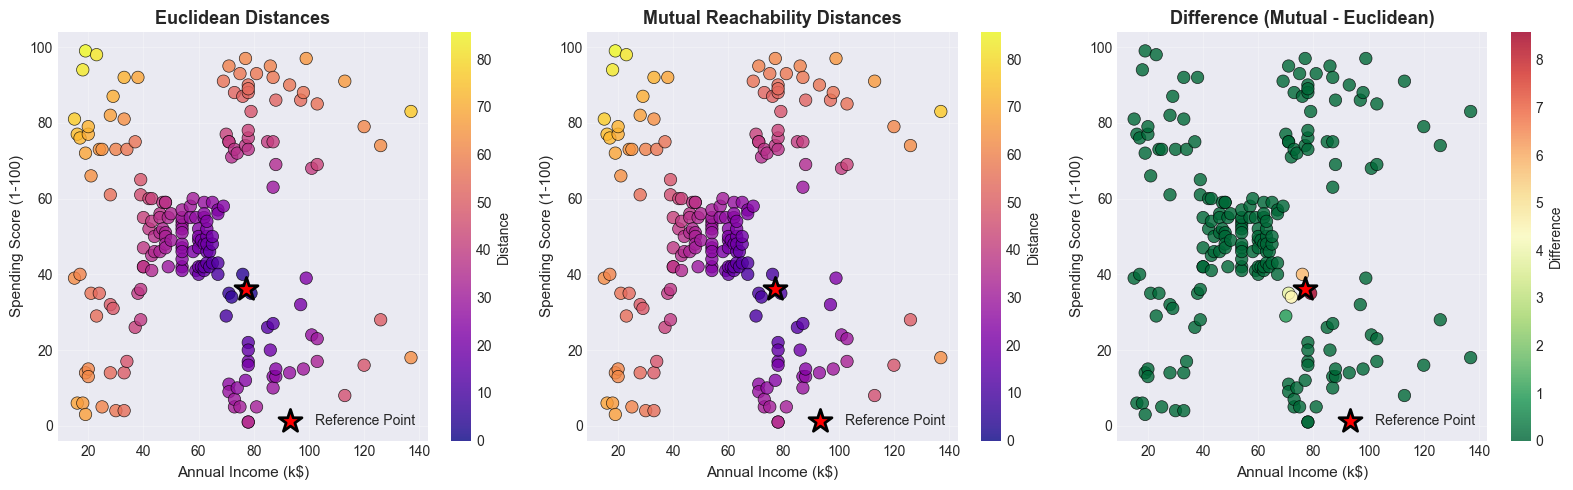

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Select a random point to visualize distances from
center_point = np.random.choice(len(X))

# Plot 1: Euclidean distances
euclidean_dists = distance_matrix[center_point]
scatter1 = axes[0].scatter(X[:, 0], X[:, 1], c=euclidean_dists, s=80, 
                           cmap='plasma', edgecolors='black', linewidth=0.5, alpha=0.8)
axes[0].scatter(X[center_point, 0], X[center_point, 1], s=300, c='red', 
                marker='*', edgecolors='black', linewidth=2, zorder=5, label='Reference Point')
plt.colorbar(scatter1, ax=axes[0], label='Distance')
axes[0].set_title('Euclidean Distances', fontsize=13, fontweight='bold')
axes[0].set_xlabel(feature_names[0], fontsize=11)
axes[0].set_ylabel(feature_names[1], fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Mutual reachability distances
mutual_dists = mutual_reachability_matrix[center_point]
scatter2 = axes[1].scatter(X[:, 0], X[:, 1], c=mutual_dists, s=80, 
                           cmap='plasma', edgecolors='black', linewidth=0.5, alpha=0.8)
axes[1].scatter(X[center_point, 0], X[center_point, 1], s=300, c='red', 
                marker='*', edgecolors='black', linewidth=2, zorder=5, label='Reference Point')
plt.colorbar(scatter2, ax=axes[1], label='Distance')
axes[1].set_title('Mutual Reachability Distances', fontsize=13, fontweight='bold')
axes[1].set_xlabel(feature_names[0], fontsize=11)
axes[1].set_ylabel(feature_names[1], fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Difference (Mutual - Euclidean)
difference = mutual_dists - euclidean_dists
scatter3 = axes[2].scatter(X[:, 0], X[:, 1], c=difference, s=80, 
                           cmap='RdYlGn_r', edgecolors='black', linewidth=0.5, alpha=0.8)
axes[2].scatter(X[center_point, 0], X[center_point, 1], s=300, c='red', 
                marker='*', edgecolors='black', linewidth=2, zorder=5, label='Reference Point')
plt.colorbar(scatter3, ax=axes[2], label='Difference')
axes[2].set_title('Difference (Mutual - Euclidean)', fontsize=13, fontweight='bold')
axes[2].set_xlabel(feature_names[0], fontsize=11)
axes[2].set_ylabel(feature_names[1], fontsize=11)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observation
- Mutual reachability distances are always ≥ Euclidean distances
- The difference is larger for points in low-density regions

### Step 3: Minimum Spanning Tree (MST)

### Mathematical Definition

A **Minimum Spanning Tree** is a subgraph that:
1. Connects all $n$ points (vertices) with $n-1$ edges
2. Has no cycles (it's a tree)
3. Minimizes the total edge weight: $\sum_{e \in \text{MST}} w(e)$

We use **Prim's Algorithm** to construct the MST with mutual reachability distances as weights.

### Algorithm: Prim's Algorithm

```
Initialize: Start with arbitrary vertex v₀
Visited = {v₀}

While Visited ≠ all vertices:
    Find minimum weight edge (u, v) where u ∈ Visited, v ∉ Visited
    Add edge (u, v) to MST
    Add v to Visited
```

### Why Build an MST?

The MST captures the **density-based connectivity structure** of the data:
- Short edges → points in same dense cluster
- Long edges → connections between clusters or to outliers

The MST provides a graph representation that preserves hierarchical cluster structure.


In [44]:
# =============================================================================
# STEP 3: BUILD MINIMUM SPANNING TREE
# =============================================================================

print("Building Minimum Spanning Tree using Prim's algorithm...")
print("=" * 70)

# Use scipy's efficient MST implementation
mst_sparse = minimum_spanning_tree(mutual_reachability_matrix)
mst_array = mst_sparse.toarray()

# Extract edges and weights
mst_edges = []
mst_weights = []

for i in range(len(mst_array)):
    for j in range(len(mst_array[i])):
        if mst_array[i, j] > 0:
            mst_edges.append((i, j))
            mst_weights.append(mst_array[i, j])

# Convert to arrays for easier manipulation
mst_edges = np.array(mst_edges)
mst_weights = np.array(mst_weights)

print(f"\nMST Statistics:")
print(f"   • Number of vertices: {len(X)}")
print(f"   • Number of edges: {len(mst_edges)} (should be n-1 = {len(X)-1})")
print(f"   • Total weight: {mst_weights.sum():.4f}")
print(f"   • Min edge weight: {mst_weights.min():.4f}")
print(f"   • Mean edge weight: {mst_weights.mean():.4f}")
print(f"   • Max edge weight: {mst_weights.max():.4f}")

# Show first few edges
print(f"\nFirst 5 MST Edges:")
print(f"{'Edge':<12} {'Point A':<10} {'Point B':<10} {'Weight':<12}")
print("-" * 50)
for idx in range(min(5, len(mst_edges))):
    i, j = mst_edges[idx]
    weight = mst_weights[idx]
    print(f"Edge {idx:<6} {i:<10} {j:<10} {weight:<12.4f}")

Building Minimum Spanning Tree using Prim's algorithm...

MST Statistics:
   • Number of vertices: 200
   • Number of edges: 199 (should be n-1 = 199)
   • Total weight: 1577.2241
   • Min edge weight: 2.2361
   • Mean edge weight: 7.9257
   • Max edge weight: 36.7696

First 5 MST Edges:
Edge         Point A    Point B    Weight      
--------------------------------------------------
Edge 0      0          4          14.7648     
Edge 1      1          3          9.8489      
Edge 2      1          7          15.1327     
Edge 3      1          11         18.4391     
Edge 4      2          6          9.0554      


### Visualization: Minimum Spanning Tree

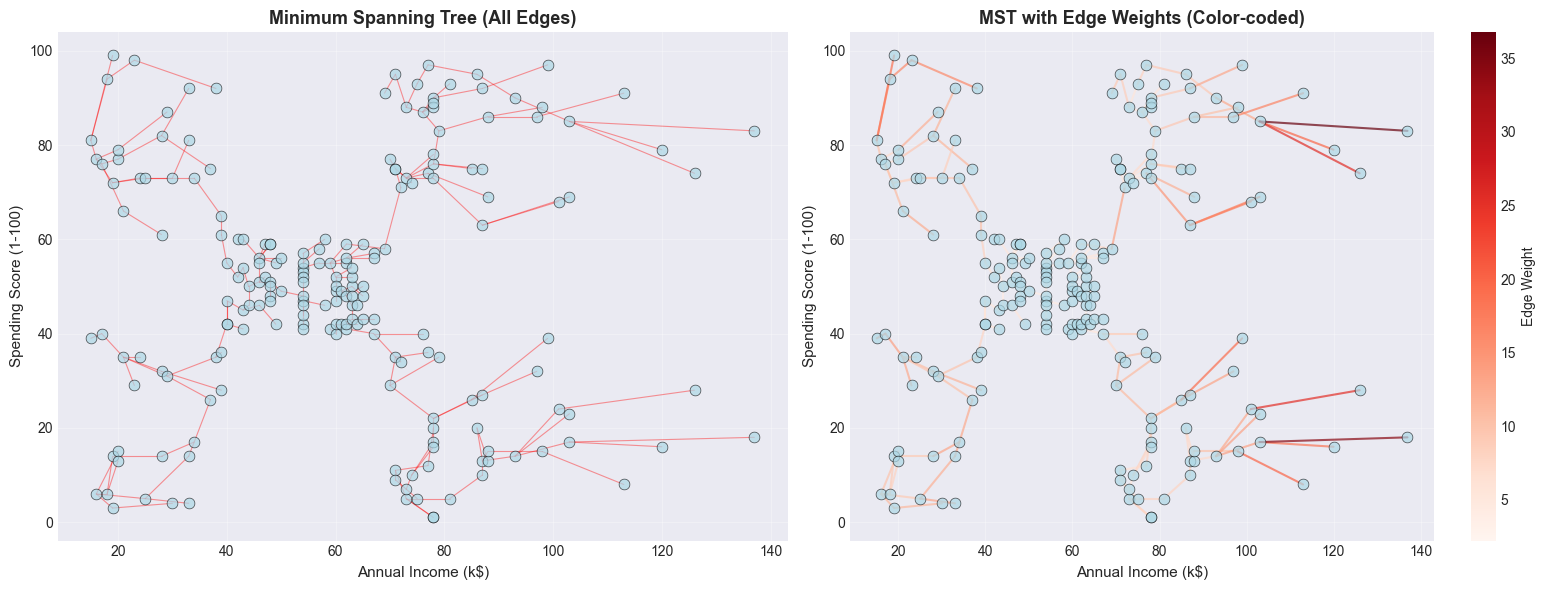

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: MST with all edges
ax1 = axes[0]
ax1.scatter(X[:, 0], X[:, 1], s=60, alpha=0.7, c='lightblue', 
            edgecolors='black', linewidth=0.5, zorder=3)

# Draw all MST edges
for (i, j), weight in zip(mst_edges, mst_weights):
    ax1.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], 
             'r-', alpha=0.4, linewidth=0.8, zorder=1)

ax1.set_title('Minimum Spanning Tree (All Edges)', fontsize=13, fontweight='bold')
ax1.set_xlabel(feature_names[0], fontsize=11)
ax1.set_ylabel(feature_names[1], fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: MST with edge weights as colors
ax2 = axes[1]
ax2.scatter(X[:, 0], X[:, 1], s=60, alpha=0.7, c='lightblue', 
            edgecolors='black', linewidth=0.5, zorder=3)

# Normalize weights for color mapping
norm_weights = (mst_weights - mst_weights.min()) / (mst_weights.max() - mst_weights.min())
cmap = plt.cm.Reds

for (i, j), weight, norm_w in zip(mst_edges, mst_weights, norm_weights):
    ax2.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], 
             color=cmap(norm_w), alpha=0.7, linewidth=1.5, zorder=1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mst_weights.min(), vmax=mst_weights.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, label='Edge Weight')

ax2.set_title('MST with Edge Weights (Color-coded)', fontsize=13, fontweight='bold')
ax2.set_xlabel(feature_names[0], fontsize=11)
ax2.set_ylabel(feature_names[1], fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Edge Weight Distribution

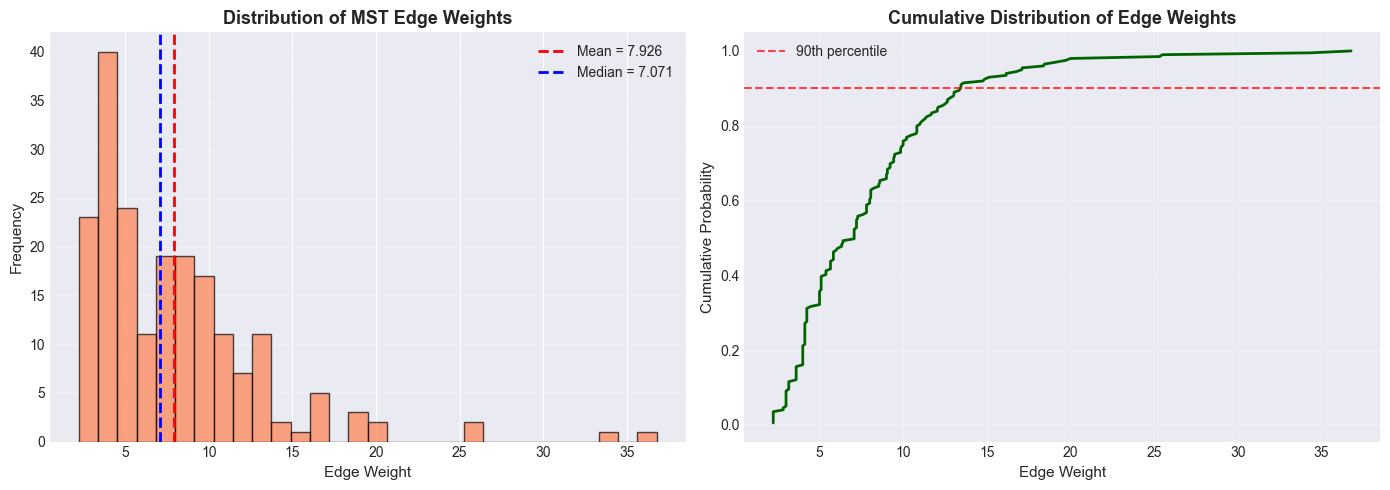

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of edge weights
axes[0].hist(mst_weights, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(mst_weights.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {mst_weights.mean():.3f}')
axes[0].axvline(np.median(mst_weights), color='blue', linestyle='--', linewidth=2, label=f'Median = {np.median(mst_weights):.3f}')
axes[0].set_xlabel('Edge Weight', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of MST Edge Weights', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative distribution
sorted_weights = np.sort(mst_weights)
cumulative = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
axes[1].plot(sorted_weights, cumulative, linewidth=2, color='darkgreen')
axes[1].axhline(0.9, color='red', linestyle='--', alpha=0.7, label='90th percentile')
axes[1].set_xlabel('Edge Weight', fontsize=11)
axes[1].set_ylabel('Cumulative Probability', fontsize=11)
axes[1].set_title('Cumulative Distribution of Edge Weights', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Note: Long edges (high weights) often represent connections between clusters or to outliers

### Step 4: Build Cluster Hierarchy

### The Process

From the MST, we build a **cluster hierarchy** (dendrogram) by:

1. **Sort** MST edges by weight: $w_1 \leq w_2 \leq ... \leq w_{n-1}$
2. **Process edges** in order from smallest to largest
3. As we add edges, **track when components merge**
4. Record the **distance** (or inverse: $\lambda = 1/d$) at which each merge occurs

### Mathematical Representation

The hierarchy can be represented as a dendrogram where:
- **Leaves** = individual data points
- **Internal nodes** = cluster merges
- **Height** = distance at which merge occurs
- **$\lambda$** (lambda) = $1/\text{distance}$ = density level

Higher $\lambda$ values mean higher density (smaller distances).

In [47]:
# =============================================================================
# STEP 4: BUILD CLUSTER HIERARCHY
# =============================================================================

# Sort edges by weight
sorted_indices = np.argsort(mst_weights)
sorted_edges = mst_edges[sorted_indices]
sorted_weights = mst_weights[sorted_indices]

# Convert to lambda (inverse distance) for density-based interpretation
lambda_values = 1.0 / sorted_weights

print(f"\n Hierarchy Statistics:")
print(f"   • Number of merges: {len(sorted_edges)}")
print(f"   • Distance range: [{sorted_weights.min():.4f}, {sorted_weights.max():.4f}]")
print(f"   • Lambda (1/distance) range: [{lambda_values.min():.4f}, {lambda_values.max():.4f}]")

print(f"\n First 5 Merges (smallest distances = highest density):")
print(f"{'Merge #':<10} {'Point A':<10} {'Point B':<10} {'Distance':<12} {'Lambda (1/d)':<15}")
print("-" * 65)
for idx in range(min(5, len(sorted_edges))):
    i, j = sorted_edges[idx]
    dist = sorted_weights[idx]
    lam = lambda_values[idx]
    print(f"{idx:<10} {i:<10} {j:<10} {dist:<12.4f} {lam:<15.4f}")

print(f"\n Last 5 Merges (largest distances = lowest density):")
print(f"{'Merge #':<10} {'Point A':<10} {'Point B':<10} {'Distance':<12} {'Lambda (1/d)':<15}")
print("-" * 65)
for idx in range(max(0, len(sorted_edges)-5), len(sorted_edges)):
    i, j = sorted_edges[idx]
    dist = sorted_weights[idx]
    lam = lambda_values[idx]
    print(f"{idx:<10} {i:<10} {j:<10} {dist:<12.4f} {lam:<15.4f}")


 Hierarchy Statistics:
   • Number of merges: 199
   • Distance range: [2.2361, 36.7696]
   • Lambda (1/distance) range: [0.0272, 0.4472]

 First 5 Merges (smallest distances = highest density):
Merge #    Point A    Point B    Distance     Lambda (1/d)   
-----------------------------------------------------------------
0          99         106        2.2361       0.4472         
1          94         100        2.2361       0.4472         
2          94         98         2.2361       0.4472         
3          94         105        2.2361       0.4472         
4          99         101        2.2361       0.4472         

 Last 5 Merges (largest distances = lowest density):
Merge #    Point A    Point B    Distance     Lambda (1/d)   
-----------------------------------------------------------------
194        182        192        20.0000      0.0500         
195        186        196        25.3180      0.0395         
196        189        197        25.4951      0.0392        

### Visualization: Dendrogram
A dendrogram shows the hierarchical clustering structure:

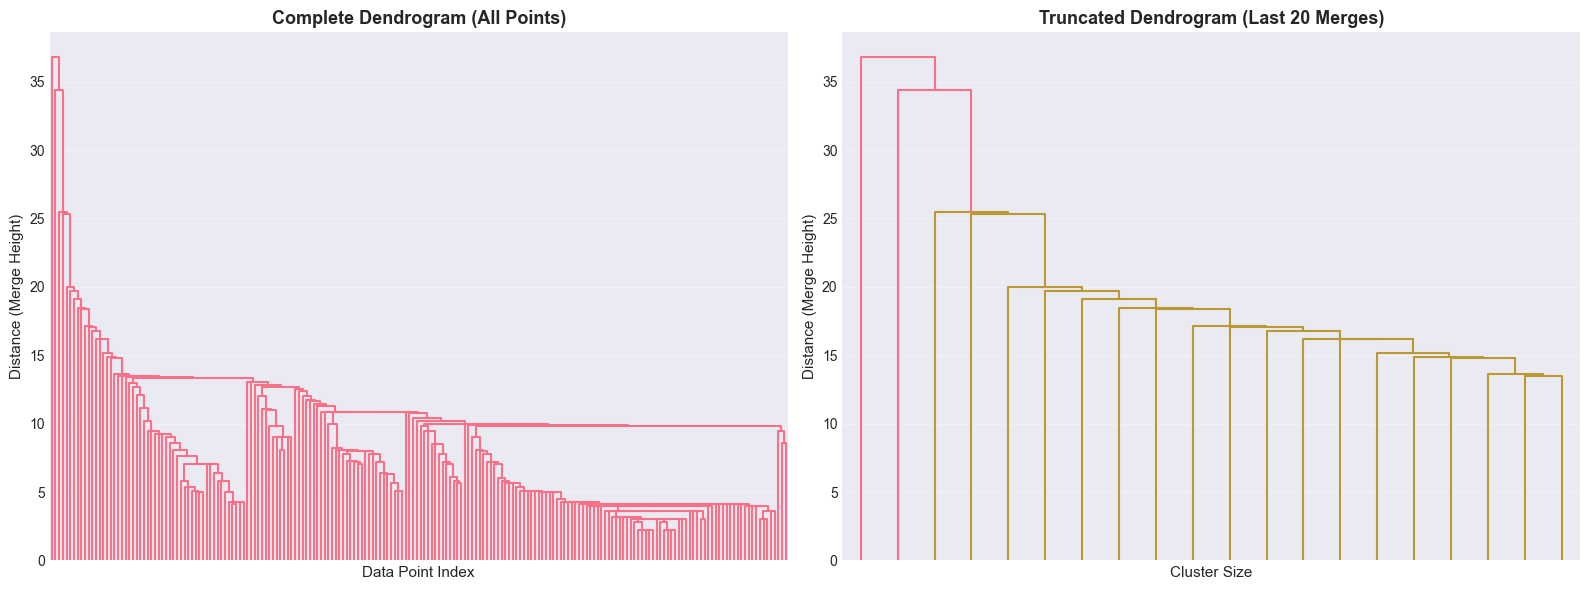

In [48]:
# Create linkage matrix for dendrogram (using single linkage on mutual reachability)
# Note: We'll use scipy's linkage for visualization purposes
from scipy.cluster.hierarchy import dendrogram, linkage

# Condensed distance matrix (upper triangle)
condensed_distances = squareform(mutual_reachability_matrix)

# Create linkage matrix using single linkage (mimics MST-based clustering)
linkage_matrix = linkage(condensed_distances, method='single')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Full dendrogram
dendro1 = dendrogram(linkage_matrix, ax=axes[0], no_labels=True, color_threshold=0)
axes[0].set_title('Complete Dendrogram (All Points)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Data Point Index', fontsize=11)
axes[0].set_ylabel('Distance (Merge Height)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Truncated dendrogram (last 20 merges)
dendro2 = dendrogram(linkage_matrix, ax=axes[1], truncate_mode='lastp', p=20, no_labels=True)
axes[1].set_title('Truncated Dendrogram (Last 20 Merges)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster Size', fontsize=11)
axes[1].set_ylabel('Distance (Merge Height)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In the dendrogram:
- Horizontal lines = clusters
- Vertical lines = merges 
- Height = distance at which merge occurs
- Taller merges = larger distances = connecting dissimilar clusters

### Step 5: Extract Stable Clusters with HDBSCAN

### Core Concept: Cluster Stability

Not all clusters in the hierarchy are "real". HDBSCAN finds **stable** clusters by:

1. **Condensing** the hierarchy (remove clusters smaller than `min_cluster_size`)
2. Computing **cluster stability** for each cluster
3. Selecting clusters that maximize overall stability

### Stability Formula

For a cluster $C$ that exists from $\lambda_{\text{birth}}$ to $\lambda_{\text{death}}$:

$\text{Stability}(C) = \sum_{p \in C} (\lambda_p - \lambda_{\text{birth}})$

where:
- $\lambda_p$ is the lambda value when point $p$ leaves the cluster (or $\lambda_{\text{death}}$)
- Higher stability = more persistent cluster

### Key Parameters

- **`min_cluster_size`**: Minimum points required to form a cluster (typically 15-50)
- **`min_samples`**: Controls how conservative the clustering is (typically 5-15)


In [49]:
# =============================================================================
# STEP 5: RUN HDBSCAN TO EXTRACT CLUSTERS
# =============================================================================

min_cluster_size = 15
print(f"Running HDBSCAN with parameters:")
print(f"   • min_cluster_size = {min_cluster_size}")
print(f"   • min_samples = {min_samples}")

# Initialize and fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    gen_min_span_tree=True,
    metric='euclidean'
)

cluster_labels = clusterer.fit_predict(X)

# Extract clustering information
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
probabilities = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

print(f"\nClustering Complete!")
print(f"\nResults:")
print(f"   • Number of clusters found: {n_clusters}")
print(f"   • Number of noise points: {n_noise} ({100*n_noise/len(X):.1f}%)")
print(f"   • Number of clustered points: {len(X) - n_noise} ({100*(len(X)-n_noise)/len(X):.1f}%)")

print(f"\nCluster Breakdown:")
print(f"{'Cluster ID':<15} {'Size':<10} {'Avg Probability':<20}")
print("-" * 50)
for cluster_id in sorted(set(cluster_labels)):
    mask = cluster_labels == cluster_id
    size = mask.sum()
    avg_prob = probabilities[mask].mean()
    
    if cluster_id == -1:
        print(f"{'Noise (-1)':<15} {size:<10} {avg_prob:<20.4f}")
    else:
        print(f"{'Cluster ' + str(cluster_id):<15} {size:<10} {avg_prob:<20.4f}")

Running HDBSCAN with parameters:
   • min_cluster_size = 15
   • min_samples = 5

Clustering Complete!

Results:
   • Number of clusters found: 3
   • Number of noise points: 41 (20.5%)
   • Number of clustered points: 159 (79.5%)

Cluster Breakdown:
Cluster ID      Size       Avg Probability     
--------------------------------------------------
Noise (-1)      41         0.0000              
Cluster 0       32         0.8817              
Cluster 1       106        0.8056              
Cluster 2       21         0.9883              


---
# Section III: Comprehensive Results Visualization

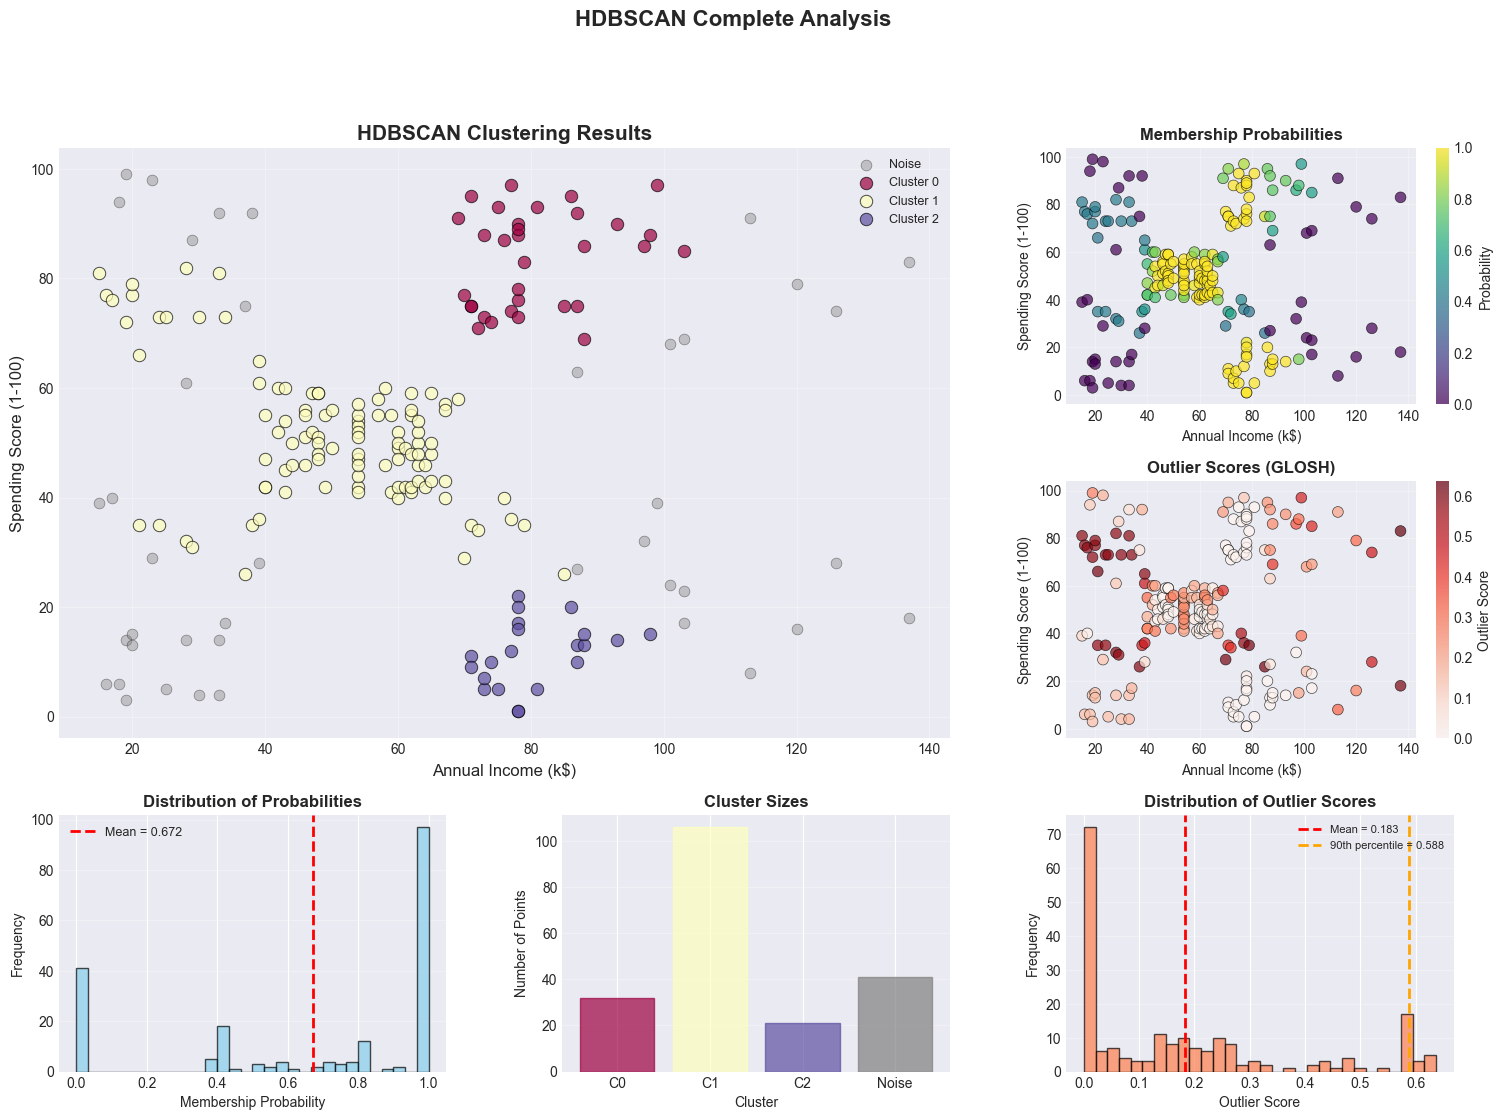

In [50]:
# Create a comprehensive visualization of results
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Color mapping for clusters
unique_labels = sorted(set(cluster_labels))
n_clusters_vis = len(unique_labels) - (1 if -1 in unique_labels else 0)
colors = plt.cm.Spectral(np.linspace(0, 1, max(n_clusters_vis, 1)))
color_map = {}
color_idx = 0
for label in unique_labels:
    if label == -1:
        color_map[label] = 'gray'
    else:
        color_map[label] = colors[color_idx]
        color_idx += 1

# Plot 1: Cluster Assignments (large)
ax1 = fig.add_subplot(gs[0:2, 0:2])
for label in unique_labels:
    mask = cluster_labels == label
    if label == -1:
        ax1.scatter(X[mask, 0], X[mask, 1], c='gray', s=60, alpha=0.4,
                   edgecolors='black', linewidth=0.5, label='Noise')
    else:
        ax1.scatter(X[mask, 0], X[mask, 1], c=[color_map[label]], s=80, alpha=0.7,
                   edgecolors='black', linewidth=0.7, label=f'Cluster {label}')

ax1.set_title('HDBSCAN Clustering Results', fontsize=15, fontweight='bold')
ax1.set_xlabel(feature_names[0], fontsize=12)
ax1.set_ylabel(feature_names[1], fontsize=12)
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Membership Probabilities
ax2 = fig.add_subplot(gs[0, 2])
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=probabilities, s=60, cmap='viridis',
                       alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter2, ax=ax2, label='Probability', fraction=0.046)
ax2.set_title('Membership Probabilities', fontsize=12, fontweight='bold')
ax2.set_xlabel(feature_names[0], fontsize=10)
ax2.set_ylabel(feature_names[1], fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Outlier Scores (GLOSH)
ax3 = fig.add_subplot(gs[1, 2])
scatter3 = ax3.scatter(X[:, 0], X[:, 1], c=outlier_scores, s=60, cmap='Reds',
                       alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter3, ax=ax3, label='Outlier Score', fraction=0.046)
ax3.set_title('Outlier Scores (GLOSH)', fontsize=12, fontweight='bold')
ax3.set_xlabel(feature_names[0], fontsize=10)
ax3.set_ylabel(feature_names[1], fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Probability Distribution
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(probabilities, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(probabilities.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean = {probabilities.mean():.3f}')
ax4.set_xlabel('Membership Probability', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Distribution of Probabilities', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Cluster Sizes
ax5 = fig.add_subplot(gs[2, 1])
cluster_sizes = [list(cluster_labels).count(label) for label in unique_labels if label != -1]
cluster_names = [f'C{label}' for label in unique_labels if label != -1]
if n_noise > 0:
    cluster_sizes.append(n_noise)
    cluster_names.append('Noise')

bars = ax5.bar(range(len(cluster_sizes)), cluster_sizes, edgecolor='black', alpha=0.7)
# Color bars
for i, (bar, name) in enumerate(zip(bars, cluster_names)):
    if name == 'Noise':
        bar.set_color('gray')
    else:
        label = int(name[1:])
        bar.set_color(color_map[label])

ax5.set_xticks(range(len(cluster_sizes)))
ax5.set_xticklabels(cluster_names)
ax5.set_xlabel('Cluster', fontsize=10)
ax5.set_ylabel('Number of Points', fontsize=10)
ax5.set_title('Cluster Sizes', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Outlier Score Distribution
ax6 = fig.add_subplot(gs[2, 2])
ax6.hist(outlier_scores, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax6.axvline(outlier_scores.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean = {outlier_scores.mean():.3f}')
threshold_90 = np.percentile(outlier_scores, 90)
ax6.axvline(threshold_90, color='orange', linestyle='--', linewidth=2,
           label=f'90th percentile = {threshold_90:.3f}')
ax6.set_xlabel('Outlier Score', fontsize=10)
ax6.set_ylabel('Frequency', fontsize=10)
ax6.set_title('Distribution of Outlier Scores', fontsize=12, fontweight='bold')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('HDBSCAN Complete Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

### Understanding the Metrics

### Membership Probability
The probability indicates how strongly a point belongs to its assigned cluster:
- **Close to 1.0**: Core point, definitely in the cluster
- **0.5 - 0.9**: Edge of cluster, some uncertainty
- **Close to 0.0**: Noise point or very uncertain assignment

### GLOSH (Global-Local Outlier Score from Hierarchies)
Measures how much of an outlier each point is:
- **Low scores (~0)**: Normal points within clusters
- **High scores**: Outliers or noise points
- Based on comparing point density to cluster density

---
# Section IV: Condensed Tree Visualization
The **condensed tree** shows the cluster hierarchy with small clusters removed.

It's condensed to only show clusters ≥ `min_cluster_size`.

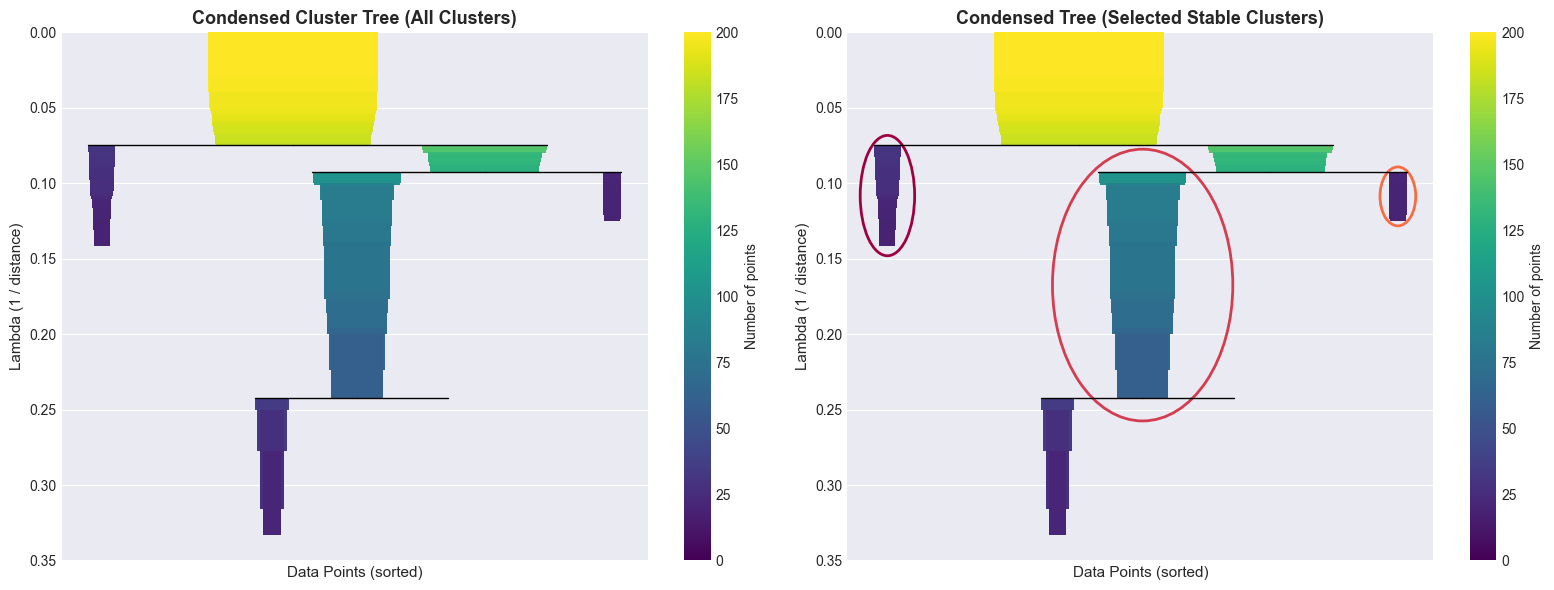

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot condensed tree
clusterer.condensed_tree_.plot(axis=axes[0], select_clusters=False, 
                               cmap='viridis', colorbar=True)
axes[0].set_title('Condensed Cluster Tree (All Clusters)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Data Points (sorted)', fontsize=11)
axes[0].set_ylabel('Lambda (1 / distance)', fontsize=11)

# Plot with selected clusters highlighted
# Create a color palette as a list instead of passing the colormap directly
spectral_palette = [plt.cm.Spectral(i / 10) for i in range(10)]
clusterer.condensed_tree_.plot(axis=axes[1], select_clusters=True,
                               selection_palette=spectral_palette,
                               cmap='viridis', colorbar=True)
axes[1].set_title('Condensed Tree (Selected Stable Clusters)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Data Points (sorted)', fontsize=11)
axes[1].set_ylabel('Lambda (1 / distance)', fontsize=11)

plt.tight_layout()
plt.show()

How to read the condensed tree:
- Y-axis (Lambda): 1/distance = density level (higher = denser)
- Vertical extent: How long a cluster persists
- Width: How many points in the cluster
- Color (right plot): Selected clusters that were extracted
- Branches that split: Cluster divisions

--- 
# Section V: Single Linkage Tree Visualization

Single Linkage Tree shows:
- Full hierarchical structure before condensing
- All possible cluster formations at different density levels
- Compare to condensed tree to see effect of min_cluster_size

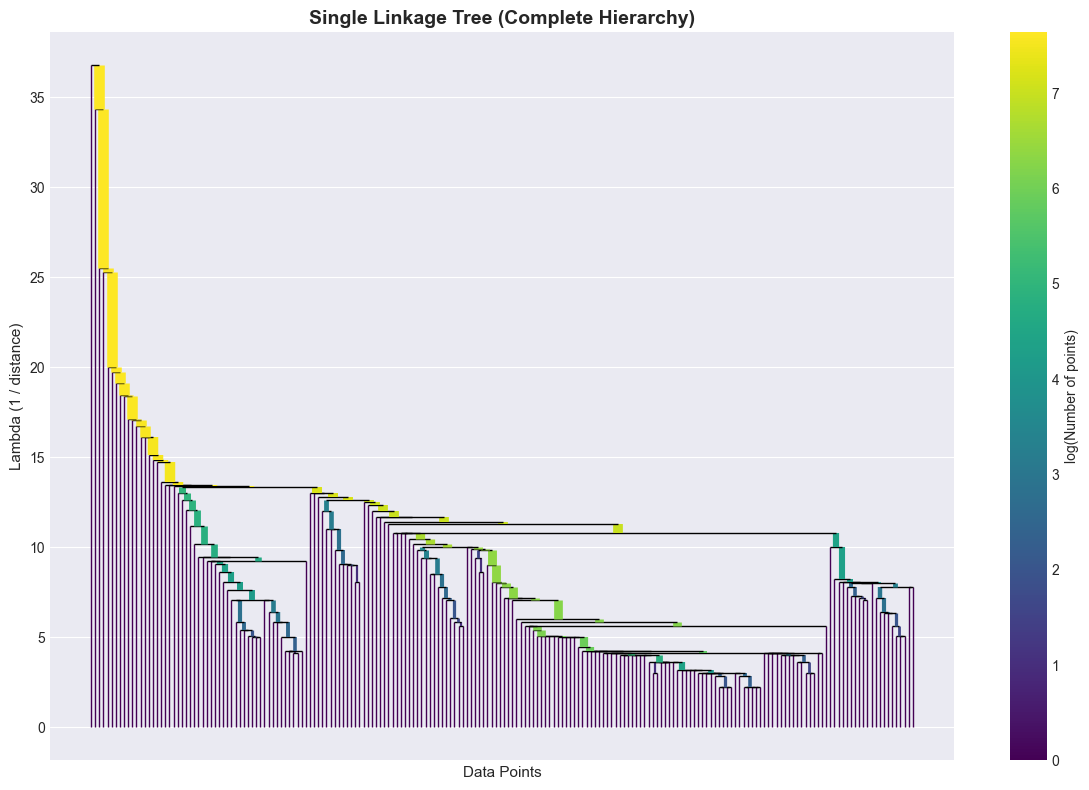

In [52]:
# Plot the single linkage tree (complete hierarchy)
fig, ax = plt.subplots(figsize=(12, 8))

clusterer.single_linkage_tree_.plot(axis=ax, cmap='viridis', colorbar=True)
ax.set_title('Single Linkage Tree (Complete Hierarchy)', fontsize=14, fontweight='bold')
ax.set_xlabel('Data Points', fontsize=11)
ax.set_ylabel('Lambda (1 / distance)', fontsize=11)

plt.tight_layout()
plt.show()

---
# Section VI. Parameter Effects Analysis
Let's explore how different parameters affect clustering results.

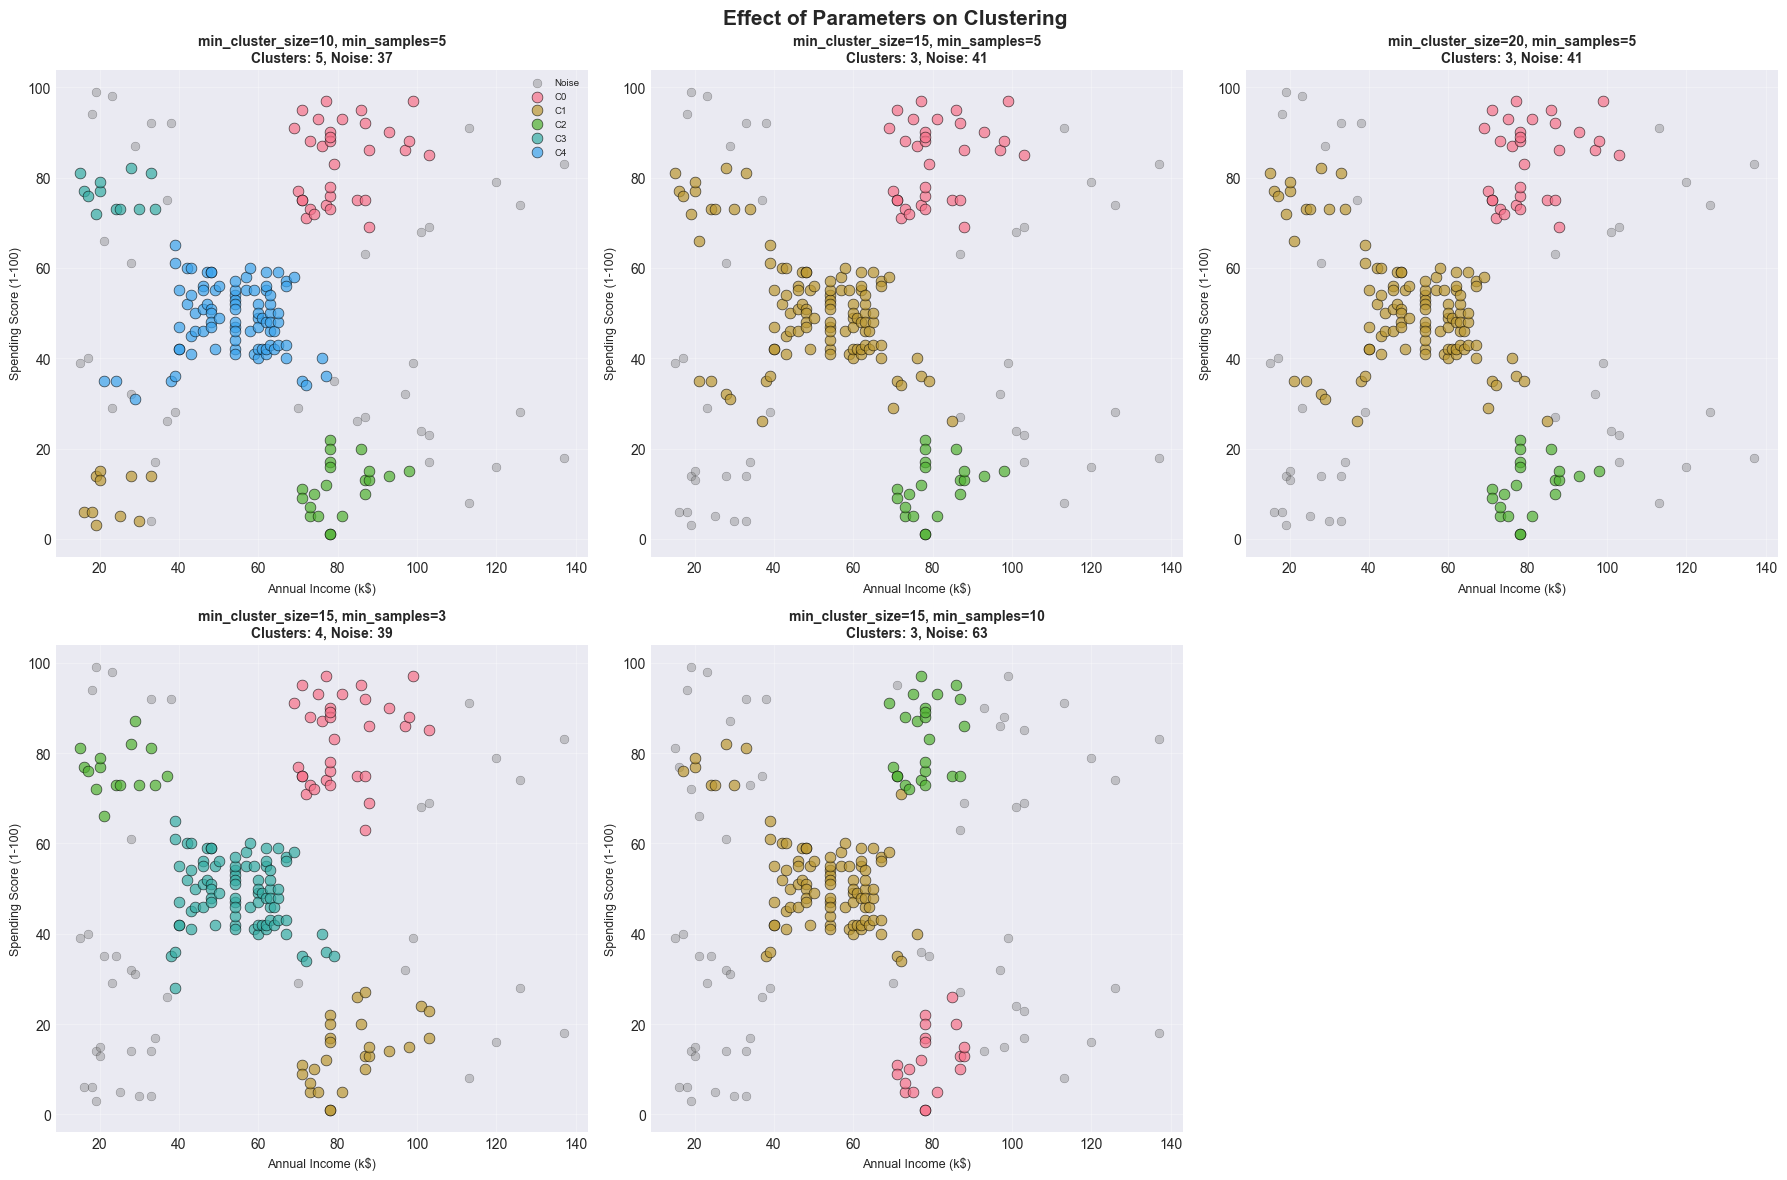

In [53]:
# Test different parameter combinations
param_combinations = [
    {'min_cluster_size': 10, 'min_samples': 5},
    {'min_cluster_size': 15, 'min_samples': 5},
    {'min_cluster_size': 20, 'min_samples': 5},
    {'min_cluster_size': 15, 'min_samples': 3},
    {'min_cluster_size': 15, 'min_samples': 10},
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, params in enumerate(param_combinations):
    clusterer_test = hdbscan.HDBSCAN(**params)
    labels_test = clusterer_test.fit_predict(X)
    
    n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise_test = list(labels_test).count(-1)
    
    # Plot
    ax = axes[idx]
    unique_labels_test = sorted(set(labels_test))
    
    for label in unique_labels_test:
        mask = labels_test == label
        if label == -1:
            ax.scatter(X[mask, 0], X[mask, 1], c='gray', s=40, alpha=0.4,
                      edgecolors='black', linewidth=0.3, label='Noise')
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=60, alpha=0.7,
                      edgecolors='black', linewidth=0.5, label=f'C{label}')
    
    ax.set_title(f"min_cluster_size={params['min_cluster_size']}, min_samples={params['min_samples']}\n"
                f"Clusters: {n_clusters_test}, Noise: {n_noise_test}",
                fontsize=10, fontweight='bold')
    ax.set_xlabel(feature_names[0], fontsize=9)
    ax.set_ylabel(feature_names[1], fontsize=9)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=7, loc='best')

# Hide the last subplot if we have fewer than 6
if len(param_combinations) < 6:
    axes[-1].axis('off')

plt.suptitle('Effect of Parameters on Clustering', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Parameter Effects:
- Higher `min_cluster_size` → Fewer, larger clusters + more noise
- Lower `min_cluster_size` → More, smaller clusters + less noise
- Higher `min_samples` → More conservative, focuses on denser regions
- Lower `min_samples` → More aggressive, accepts lower density

---

# Section VII. Summary and Key Takeaways

## HDBSCAN Algorithm Steps

1. **Core Distance**: $\text{core}_k(p) = d(p, N_k(p))$
   - Measures local density around each point

2. **Mutual Reachability**: $d_{\text{mreach}}(a, b) = \max\{\text{core}_k(a), \text{core}_k(b), d(a, b)\}$
   - Smooths distances based on local density

3. **Minimum Spanning Tree**: Connect all points with minimum total edge weight
   - Captures density-based connectivity structure

4. **Build Hierarchy**: Process edges from smallest to largest distance
   - Creates dendrogram of cluster formations

5. **Extract Clusters**: Select stable clusters that persist across density levels
   - Maximizes cluster stability scores

## Key Advantages

- **Automatic cluster detection** - No need to specify number of clusters  
- **Handles varying density** - Unlike DBSCAN with fixed epsilon  
- **Identifies outliers** - Points labeled as noise (-1)  
- **Arbitrary shapes** - Not limited to spherical clusters  
- **Soft clustering** - Provides membership probabilities  
- **Hierarchical structure** - Explore clustering at multiple scales  

## When to Use HDBSCAN

- Unknown number of clusters  
- Clusters with different densities  
- Need to identify outliers/anomalies  
- Hierarchical structure in data  
- Non-spherical cluster shapes  

## Parameter Tuning Guidelines

### `min_samples` (typically 5-15)
- Controls how conservative clustering is
- Higher → More conservative, requires higher density
- Lower → More aggressive, accepts lower density
- Start with 5 and adjust based on results

### `min_cluster_size` (typically 15-50)
- Minimum points to form a valid cluster
- Higher → Fewer, larger clusters + more noise
- Lower → More, smaller clusters + less noise
- Should reflect domain knowledge about meaningful cluster size

# End of Tutorial 
Hopefully, you've learned about:
1. Mathematical foundations of HDBSCAN
2. Step-by-step algorithm walkthrough
3. How to visualize each stage
4. How to interpret results
5. How to tune parameters

Next steps:
- Try different parameter values
- Load your own dataset
- Experiment with different distance metrics
- Compare HDBSCAN with other clustering algorithms